<img src="./images/ibm-logo.png" alt="ibm-logo" align="center" style="width: 200px;"/>

**Advanced Data Science with IBM**

<hr />

### Capstone Project


# Use Case and Data Source

**Project Description**

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

<img src="./images/tweet_screenshot.png" alt="tweet_screenshot" align="center" style="width: 250px;"/>

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine. The objective of this project is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

**Dataset**

The dataset is open source and is available on [kaggle](https://www.kaggle.com/vstepanenko/disaster-tweets). It contains over 11,000 tweets associated with disaster keywords like “crash”, “quarantine”, and “bush fires” as well as the location and keyword itself.

The tweets were collected on Jan 14th, 2020.

Some of the topics people were tweeting:

* The eruption of Taal Volcano in Batangas, Philippines
* Coronavirus
* Bushfires in Australia
* Iran downing of the airplane flight PS752

Disclaimer: The dataset contains text that may be considered profane, vulgar, or offensive.

# Initial Data Exploration

**What files do I need?**

I used the kaggle API to fetch the file *tweets.csv*. I created an API token to get the kaggle.json file and then from my local directory I ran the command:

`kaggle datasets download -d vstepanenko/disaster-tweets`

**What should I expect the data format to be?**

Each sample in the dataset has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

**What am I predicting?**

I am predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.


**Columns**

`id` - a unique identifier for each tweet
`text` - the text of the tweet
`location` - the location the tweet was sent from (may be blank)
`keyword` - a particular keyword from the tweet (may be blank)
`target` - this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
import sys, time, re, os
import itertools
from string import punctuation, printable
import numpy as np
import pandas as pd
import spacy
import joblib
from collections import Counter
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.datasets import load_files
import seaborn as sns

In [15]:
%%writefile disaster_tweets_nlp.data_exp.py
#!/usr/bin/env python

import sys, time, re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

DATA_DIR = os.path.join(".","data")
IMAGE_DIR = os.path.join(".","images")

def save_fig(fig_id, tight_layout=True, image_path=IMAGE_DIR):
    """
    save the image as png file in the image directory
    """
    
    ## Check the data directory
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    
    path = os.path.join(image_path, fig_id + ".png")
    print("...saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def ingest_data(datadir=DATA_DIR, filename="tweets.csv"):
    """
    ingest tweets dataset
    """
    
    print("Ingesting data")
    
    ## load csv file from data directory
    tweets = pd.read_csv(os.path.join(datadir,filename))
    
    ## quality checks
    print("---------------------------")
    
    ## check duplicates
    is_duplicate = tweets.duplicated(subset=["id"])
    print("...number of duplicates:", len(tweets[is_duplicate]))
    
    ## check missing data
    total = tweets.isnull().sum().sort_values(ascending=False)
    percent = (tweets.isnull().sum()/tweets.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print("...missing values: \n {}".format(missing_data.head()))
    print("---------------------------")
    
    return tweets

def summarize_data(corpus):
    """
    print statements and visualizations to summarize the corpus
    """
    
    print("Summarize data")
    
    # get the documents size
    df_doc_size = pd.Series([len(str(doc).split(" ")) for doc in corpus])
    
    # get the tokens in the corpus
    df_tokens = pd.Series([token for doc in corpus for token in str(doc).split(" ")])
    
    print("---------------------------")
    print("num docs", len(corpus))
    print("median tokens", df_doc_size.median())
    print("num tokens", len(df_tokens))
    print("unique tokens", len(df_tokens.value_counts()))
    print("---------------------------")
    
    # make plots
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    sns.distplot(df_doc_size, ax=ax1)
    ax1.set_title("Document Sizes")
    
    sns.distplot(df_tokens.value_counts().values, ax=ax2)
    ax2.set_title("Tokens Counts")
    save_fig("summarize_data")
    
if __name__ == "__main__":
    
    run_start = time.time()
    
    ## load tweets
    tweets = ingest_data()
    
    ## summarize data
    summarize_data(tweets.text.values.tolist())
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")


Overwriting disaster_tweets_nlp.data_exp.py


Ingesting data
---------------------------
...number of duplicates: 0
...missing values: 
           Total   Percent
location   3418  0.300616
target        0  0.000000
text          0  0.000000
keyword       0  0.000000
id            0  0.000000
---------------------------
Summarize data
---------------------------
num docs 11370
median tokens 18.0
num tokens 195179
unique tokens 45250
---------------------------
...saving figure summarize_data
METADATA
...run time: 0:00:00
done


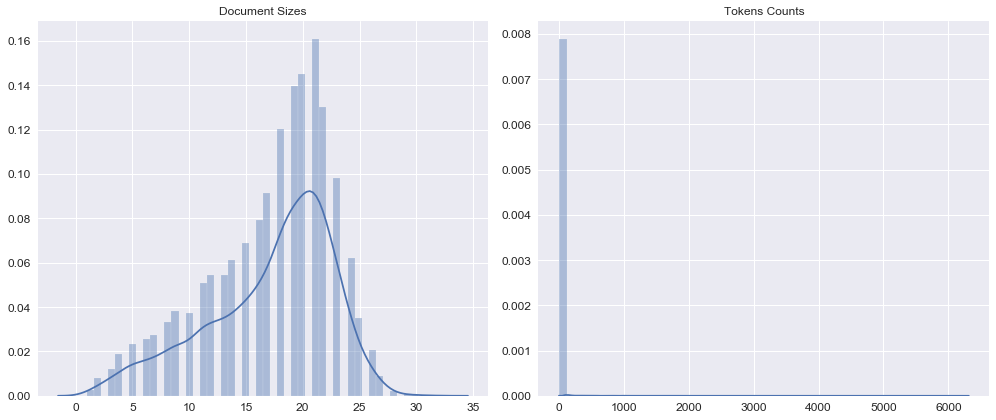

In [16]:
%run disaster_tweets_nlp.data_exp.py